In [1]:
import torch
import pickle
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import numpy as np
from torchvision import transforms, datasets

batch_size = 64
num_epochs = 10
learning_rate = 0.0001

def load_cifar10_data(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

def load_data():
    train_transform = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomCrop(32, padding=4),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    test_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
    test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

    return train_loader, test_loader

train_loader, test_loader = load_data()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Files already downloaded and verified
Files already downloaded and verified


In [2]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        # self.shortcut = nn.Sequential()
        # if stride != 1 or in_planes != self.expansion*planes:
        #     self.shortcut = nn.Sequential(
        #         nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
        #         nn.BatchNorm2d(self.expansion*planes)
        #     )

    def forward(self, x):
        out = nn.functional.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        # out += self.shortcut(x)
        out = nn.functional.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = nn.functional.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = nn.functional.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

def ResNet18():
    return ResNet(BasicBlock, [2,2,2,2])

model = ResNet18().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[100,200], gamma=0.1)

def train(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for batch_idx, (data, targets) in enumerate(train_loader):
        data, targets = data.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

        if batch_idx % 100 == 0:
            print('Batch: {}, Loss: {:.3f}, Accuracy: {:.3f}'.format(batch_idx, running_loss/(batch_idx+1), 100.*correct/total))

    train_loss = running_loss / len(train_loader)
    train_acc = 100.*correct/total

    return train_loss, train_acc

def test(model, test_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))

    with torch.no_grad():
        for data, targets in test_loader:
            data, targets = data.to(device), targets.to(device)
            outputs = model(data)
            loss = criterion(outputs, targets)

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

            for i in range(targets.size(0)):
                label = targets[i]
                class_correct[label] += predicted[i].eq(label).item()
                class_total[label] += 1

    test_loss = running_loss / len(test_loader)
    test_acc = 100.*correct/total
    class_acc = [100. * class_correct[i] / class_total[i] for i in range(10)]

    print('Test Loss: {:.3f}, Test Accuracy: {:.3f}'.format(test_loss, test_acc))
    print('Accuracy of each class:', class_acc)

    return test_loss, test_acc

train_losses = []
train_accs = []
test_losses = []
test_accs = []

for epoch in range(num_epochs):
    train_loss, train_acc = train(model, train_loader, criterion, optimizer, device)
    test_loss, test_acc = test(model, test_loader, criterion, device)
    scheduler.step()
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    test_losses.append(test_loss)
    test_accs.append(test_acc)

Batch: 0, Loss: 2.293, Accuracy: 15.625
Batch: 100, Loss: 1.920, Accuracy: 27.336
Batch: 200, Loss: 1.789, Accuracy: 32.820
Batch: 300, Loss: 1.707, Accuracy: 35.995
Batch: 400, Loss: 1.643, Accuracy: 38.681
Batch: 500, Loss: 1.590, Accuracy: 40.924
Batch: 600, Loss: 1.540, Accuracy: 42.970
Batch: 700, Loss: 1.494, Accuracy: 44.773
Test Loss: 1.202, Test Accuracy: 56.970
Accuracy of each class: [67.0, 44.3, 34.5, 27.0, 49.7, 46.5, 87.4, 61.6, 74.0, 77.7]
Batch: 0, Loss: 1.006, Accuracy: 67.188
Batch: 100, Loss: 1.102, Accuracy: 60.767
Batch: 200, Loss: 1.089, Accuracy: 61.186
Batch: 300, Loss: 1.074, Accuracy: 61.695
Batch: 400, Loss: 1.054, Accuracy: 62.383
Batch: 500, Loss: 1.031, Accuracy: 63.308
Batch: 600, Loss: 1.012, Accuracy: 64.120
Batch: 700, Loss: 1.000, Accuracy: 64.718
Test Loss: 1.006, Test Accuracy: 65.880
Accuracy of each class: [77.3, 69.4, 79.0, 33.2, 62.0, 64.9, 72.0, 55.0, 78.0, 68.0]
Batch: 0, Loss: 0.946, Accuracy: 60.938
Batch: 100, Loss: 0.848, Accuracy: 69.957


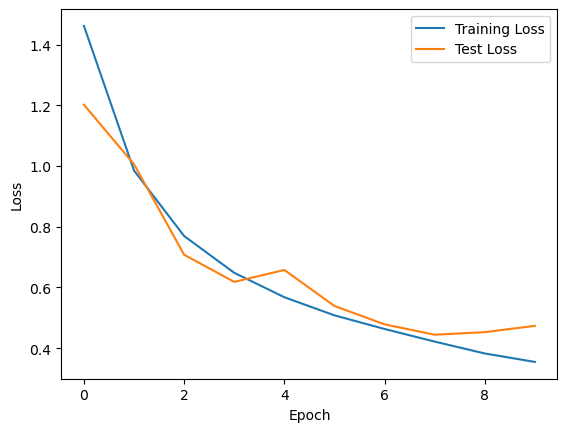

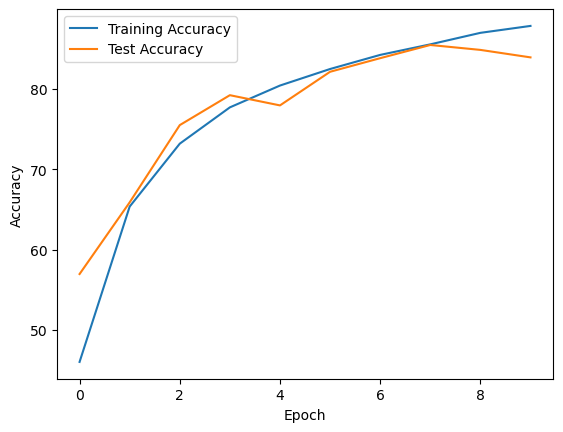

In [3]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
import matplotlib.pyplot as plt
plt.figure()
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure()
plt.plot(train_accs, label='Training Accuracy')
plt.plot(test_accs, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()